In [1]:
#  Import Libraries
import pandas as pd
import numpy as np
import joblib
from google.colab import files


In [19]:
# Step 2: Upload Required Files

uploaded = files.upload()


Saving course_recommendation_model.pkl to course_recommendation_model (2).pkl
Saving courses_cleaned_fixed.csv to courses_cleaned_fixed.csv
Saving new_students_fixed.csv to new_students_fixed.csv
Saving students_updated.csv to students_updated (2).csv


In [20]:
# Step 3: Load Datasets
students_df = pd.read_csv('students_updated.csv')
courses_df = pd.read_csv('courses_cleaned.csv')
new_students = pd.read_csv('new_students.csv')


In [21]:
#  Step 4: Load the Trained Model
model = joblib.load('course_recommendation_model.pkl')


In [22]:
# ✅ Step 3: Try model prediction
try:
    model = joblib.load("course_recommendation_model.pkl")
    X_new = new_students[['gpa', 'attendance', 'extracurricular', 'career_goal']]
    new_students['success_prob'] = model.predict_proba(X_new)[:, 1]
    use_prediction = True
except Exception as e:
    print("⚠️ Skipping prediction, reason:", e)
    new_students['success_prob'] = None
    use_prediction = False


⚠️ Skipping prediction, reason: Found unknown categories ['Project Management', 'UI/UX Design', 'AI & Robotics', 'Finance', 'Cybersecurity', 'Marketing'] in column 0 during transform


In [23]:
# ✅ Step 4: Define the Recommendation Function
def recommend_courses_for_new_student(student_profile):
    goal = student_profile['career_goal']

    # Look for similar successful students
    similar_students = students_df[
        (students_df['career_goal'] == goal) &
        (students_df['success'] == 1)
    ]

    if not similar_students.empty:
        keyword = goal.split()[0]  # basic fuzzy match
        matched = courses_df[courses_df['course_name'].str.contains(keyword, case=False, na=False)]
        if not matched.empty:
            return matched[['course_name', 'difficulty']].drop_duplicates().reset_index(drop=True)

    # Fallback to beginner courses if no match
    if 'prerequisites' in courses_df.columns:
        return courses_df[courses_df['prerequisites'].isnull()][['course_name', 'difficulty']].drop_duplicates().reset_index(drop=True)
    else:
        return courses_df[['course_name', 'difficulty']].drop_duplicates().reset_index(drop=True)


In [25]:
# Step 5: Generate and Save Recommendations
recommendations_output = []

for _, row in new_students.iterrows():
    print(f"\n🧑 Student ID: {row['student_id']} | Goal: {row['career_goal']}")
    if use_prediction and row['success_prob'] is not None:
        print(f"🤖 Predicted Success: {row['success_prob']:.2f}")

    rec = recommend_courses_for_new_student(row)
    print("📘 Courses:")
    print(rec)

    recommendations_output.append({
        "student_id": row['student_id'],
        "career_goal": row['career_goal'],
        "recommended_courses": ', '.join(rec['course_name'].tolist())
    })

# Save output
recommendation_df = pd.DataFrame(recommendations_output)
recommendation_df.to_csv("final_recommendations.csv", index=False)
files.download("final_recommendations.csv")


Streaming output truncated to the last 5000 lines.
0  Software Testing and Automation       Hard

🧑 Student ID: 1242 | Goal: Healthcare
📘 Courses:
                 course_name difficulty
0  Healthcare Data Analytics       Easy

🧑 Student ID: 1243 | Goal: Data Science
📘 Courses:
                        course_name difficulty
0           Python for Data Science       Easy
1                Big Data and Spark       Easy
2         Statistical Data Analysis       Hard
3        Data Wrangling with Pandas       Easy
4  Database Optimization Techniques       Easy
5         Healthcare Data Analytics       Easy

🧑 Student ID: 1244 | Goal: Business
📘 Courses:
                           course_name difficulty
0  Business Intelligence with Power BI       Easy
1      Business Negotiation Strategies       Hard
2     Pharmaceutical Business Strategy       Hard

🧑 Student ID: 1245 | Goal: UI/UX Design
📘 Courses:
                                 course_name difficulty
0                    Python for Data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Final recommendation visualization**

In [26]:
from google.colab import files
import pandas as pd

# Upload your final_recommendations.csv file
uploaded = files.upload()


Saving final_recommendations.csv to final_recommendations (1).csv


In [27]:
# Load the recommendations CSV
recommendation_df = pd.read_csv("final_recommendations.csv")

# Extract individual courses from the comma-separated list
all_courses = recommendation_df['recommended_courses'].str.split(', ')
flat_course_list = [course.strip() for sublist in all_courses for course in sublist]

# Count how often each course was recommended
course_counts = pd.Series(flat_course_list).value_counts().reset_index()
course_counts.columns = ['course_name', 'recommendation_count']


<ipython-input-28-f57f08d56fe2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=course_counts.head(10), x='recommendation_count', y='course_name', palette='Blues_d')


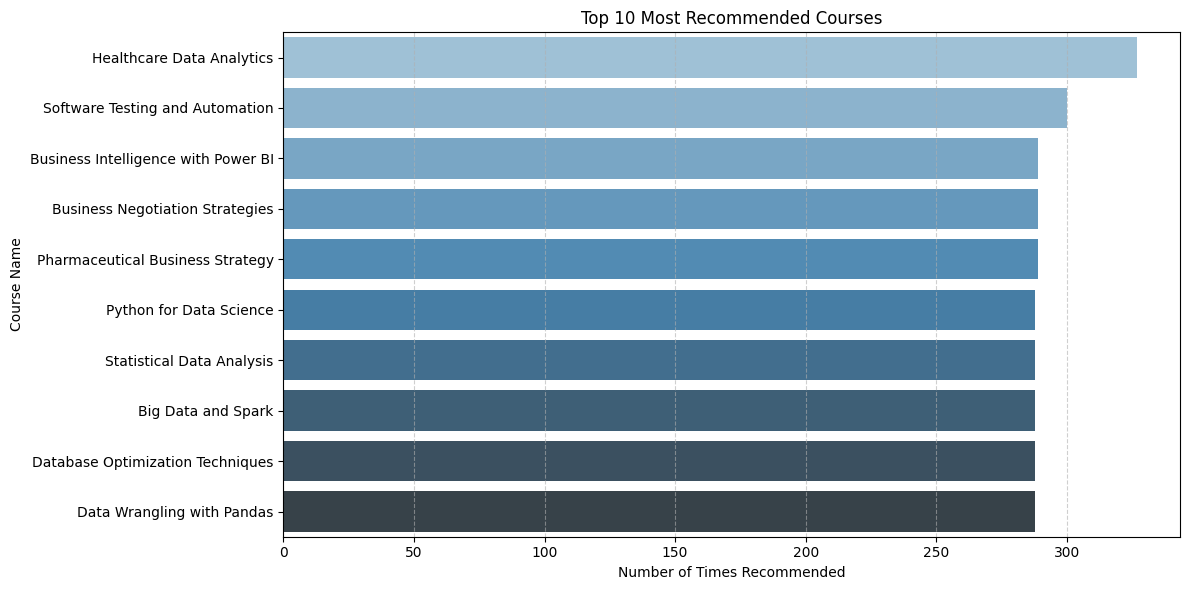

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.figure(figsize=(12, 6))
sns.barplot(data=course_counts.head(10), x='recommendation_count', y='course_name', palette='Blues_d')

plt.title("Top 10 Most Recommended Courses")
plt.xlabel("Number of Times Recommended")
plt.ylabel("Course Name")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
